<a href="https://colab.research.google.com/github/Andarsan/working_with_care/blob/main/github_%D0%A0%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%D1%81_%D0%B7%D0%B0%D0%B1%D0%BE%D1%82%D0%BE%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Работа с заботой


**Нужно разработать модель машинного обучения, которая сможет предсказать уровень удовлетворенности сотрудника на основе данных заказчика**

 для этого нужно:
- изучить данные сделайте выводы
- выполнить предобработку, пропуски заполнить в пайплайн

- подготовку признаков выполнить в пайплайне, дополнив пайплайн шагами предобработки
    - при кодировании учесть особенности признаков и моделей и использовать как минимум два кодировщика

- обучить  две модели, одну линейную модель, а вторую дерево решений.
  - подобрать гиперпараметры для одной модели с помощью одного из инструментов

- выбрать лучшую модель и проверить её качество
  - выбор зделать на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»)


**Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.**

- использовать те же входные признаки, что и в предыдущей задаче
  - целевой признак quit — увольнение сотрудника из компании

 - изучить данные и сделайте выводы, выполнить предобработку, пропуски заполнить в пайплайна
     
- составить портрет «уволившегося сотрудника»
  - в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности
  - сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании

- визуализируем и сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников
  - используем данные с обоими целевыми признаками тестовой выборки

  - если, job_satisfaction_rate и quit действительно связаны и мы получим необходимое значение метрики в первой задаче
    - тогда добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи

- выполнить предобработку, пропуски заполнить в пайплайне

- подготовку признаков выполнить в пайплайне, дополнив пайплайн шагами предобработки
    - при кодировании учесть особенности признаков и моделей и использовать как минимум два кодировщика
    - обучить как минимум три модели
      - для двух из них подобрать гиперпараметры
      - проверить качество лучшей модели
      - метрика оценки качества в этой задаче ROC-AUC

* тренировочная выборка **`train_job_satisfaction_rate.csv`**
* входные признаки тестовой выборки **`test_features.csv`**
* целевой признак тестовой выборки **`test_target_job_satisfaction_rate.csv`**

|||
|:-|:-|
|id| — уникальный идентификатор сотрудника|
|dept| — отдел, в котором работает сотрудник|
|level| — уровень занимаемой должности|
|workload| — уровень загруженности сотрудника|
|employment_years| — длительность работы в компании (в годах);|
|last_year_promo| — показывает, было ли повышение за последний год|
|last_year_violations| — показывает, нарушал ли сотрудник трудовой договор за последний год|
|supervisor_evaluation| — оценка качества работы сотрудника, которую дал руководитель|
|salary| — ежемесячная зарплата сотрудника|
|job_satisfaction_rate| — уровень удовлетворённости сотрудника работой в компании, целевой признак|

* тренировочная выборка **`train_quit.csv`**
* входные признаки тестовой выборки те же, что и в прошлой задаче **'test_features.csv**
* целевой признак тестовой выборки **`test_target_quit.csv`**




## Шаг 1-3. Загрузка данных
* Шаг 2. Предобработка данных
* Шаг 3. Исследовательский анализ данных

In [289]:
%%capture
import pandas as pd
import copy
import matplotlib.pyplot as plt
from importlib import reload
import numpy as np
import seaborn as sns
# загружаем класс pipeline
from sklearn.pipeline import Pipeline
# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer
## загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
## загружаем нужные модели
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
## загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
# кодировать категории [0,1,0,0,0]
from sklearn.preprocessing import OneHotEncoder
# создать матрицу с цифарками (стардатизация)
from sklearn.preprocessing import StandardScaler
# ищет линейную зависимость от всех значений во всех колонках к одному значению y
from sklearn.linear_model import LogisticRegression, LinearRegression
import os
# Вычисление матрицы корреляции с использованием phik
! pip install phik
import phik
# своя метрика
from sklearn.metrics import make_scorer
# убрать предупреждения
import warnings
# import nltk
import sklearn
try:
  from google.colab import drive
  drive.mount('/content/drive')
except Exception as ex:
    template = "An exception of type {0} occurred. Arguments:\n{1!r}"
    message = template.format(type(ex).__name__, ex.args)
    print(message)
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [290]:
pth1 = '/datasets'#/ferma_main.csv'
pth2 = '/content/drive/MyDrive/Colab Notebooks/all_project'#/ferma_main.csv'
pth3 = 'C:/Users/andar/Downloads'
if os.path.exists(pth1):
  pth = pth1
elif os.path.exists(pth2):
  pth = pth2
elif os.path.exists(pth3):
  pth = pth3
else:
  pth = 'Something is wrong'
display(f'рабочий каталог: {pth}')

'рабочий каталог: C:/Users/andar/Downloads'

### `train_job_satisfaction_rate.csv`

In [291]:
df_train_job = pd.read_csv(pth + '/train_job_satisfaction_rate.csv')
display(df_train_job.head(5))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [292]:
df_train_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


* пропуски есть заполним их в пайплайне
* формат данных кодируем в пайплайне

In [293]:
df_train_job['id'].duplicated().sum()

0

* все работники уникальны

In [294]:
_for =[ 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate']
for i in _for:
  display(f'--------------{i}---------------')
  display(df_train_job[i].unique())


'--------------dept---------------'

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

'--------------level---------------'

array(['junior', 'middle', 'sinior', nan], dtype=object)

'--------------workload---------------'

array(['medium', 'high', 'low'], dtype=object)

'--------------employment_years---------------'

array([ 2,  1,  4,  7,  9,  6,  3, 10,  8,  5], dtype=int64)

'--------------last_year_promo---------------'

array(['no', 'yes'], dtype=object)

'--------------last_year_violations---------------'

array(['no', 'yes'], dtype=object)

'--------------supervisor_evaluation---------------'

array([1, 5, 2, 3, 4], dtype=int64)

'--------------salary---------------'

array([24000, 38400, 12000, 18000, 22800, 30000, 56400, 52800, 13200,
       54000, 19200, 40800, 34800, 27600, 26400, 33600, 50400, 15600,
       14400, 25200, 72000, 31200, 32400, 48000, 43200, 46800, 58800,
       84000, 44400, 39600, 37200, 21600, 28800, 62400, 60000, 42000,
       49200, 55200, 57600, 68400, 45600, 51600, 64800, 80400, 20400,
       61200, 76800, 69600, 16800, 36000, 63600, 81600, 66000, 74400,
       67200, 70800, 73200, 75600, 79200, 94800, 78000, 88800, 92400,
       85200, 91200, 98400, 96000, 97200], dtype=int64)

'--------------job_satisfaction_rate---------------'

array([0.58, 0.76, 0.11, 0.37, 0.2 , 0.78, 0.56, 0.44, 0.14, 0.47, 0.74,
       0.42, 0.32, 0.57, 0.16, 0.69, 0.33, 0.64, 0.39, 0.8 , 0.79, 0.17,
       0.65, 0.18, 0.19, 0.49, 0.63, 0.22, 0.23, 0.5 , 0.35, 0.3 , 0.77,
       0.88, 0.59, 0.21, 0.36, 0.85, 0.7 , 0.48, 0.6 , 0.1 , 0.27, 0.71,
       0.86, 0.54, 0.73, 0.46, 0.31, 0.72, 0.51, 0.61, 0.81, 0.99, 0.15,
       0.91, 0.68, 0.4 , 0.89, 0.67, 0.75, 0.98, 0.26, 0.45, 0.92, 0.82,
       0.66, 0.55, 0.38, 0.53, 0.84, 0.52, 0.24, 0.62, 0.41, 0.28, 0.09,
       0.97, 0.83, 0.25, 0.43, 0.04, 0.13, 0.29, 0.95, 0.93, 0.87, 0.08,
       0.94, 0.07, 0.34, 0.9 , 0.12, 0.06, 0.96, 0.05, 1.  , 0.03])

* всё ок кроме nan но это исправим

In [295]:
_for =[ 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate']
for i in _for:
  display(df_train_job[i].value_counts())
  display(f'-----------------------------')

dept
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: count, dtype: int64

'-----------------------------'

level
junior    1894
middle    1744
sinior     358
Name: count, dtype: int64

'-----------------------------'

workload
medium    2066
low       1200
high       734
Name: count, dtype: int64

'-----------------------------'

employment_years
1     966
2     785
3     483
4     384
5     380
7     301
6     287
8     193
9     130
10     91
Name: count, dtype: int64

'-----------------------------'

last_year_promo
no     3880
yes     120
Name: count, dtype: int64

'-----------------------------'

last_year_violations
no     3441
yes     559
Name: count, dtype: int64

'-----------------------------'

supervisor_evaluation
4    1603
3    1263
5     546
2     387
1     201
Name: count, dtype: int64

'-----------------------------'

salary
24000    187
27600    184
21600    167
26400    167
28800    164
        ... 
74400      1
85200      1
91200      1
98400      1
97200      1
Name: count, Length: 68, dtype: int64

'-----------------------------'

job_satisfaction_rate
0.65    94
0.67    90
0.68    85
0.69    84
0.66    81
        ..
0.04     4
0.99     4
0.98     3
0.03     3
1.00     2
Name: count, Length: 98, dtype: int64

'-----------------------------'

In [296]:
df_train_job[['employment_years','salary']].describe()

,employment_years,salary
count,4000.000000,4000.000000
mean,3.718500,33926.700000
std,2.542513,14900.703838
min,1.000000,12000.000000
25%,2.000000,22800.000000
50%,3.000000,30000.000000
75%,6.000000,43200.000000
max,10.000000,98400.000000


* медиана и средняя с большим но всё таки нормальны разбросом
*  выбросов больших нет

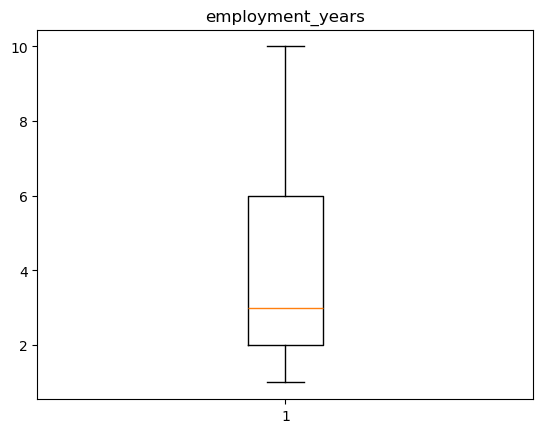

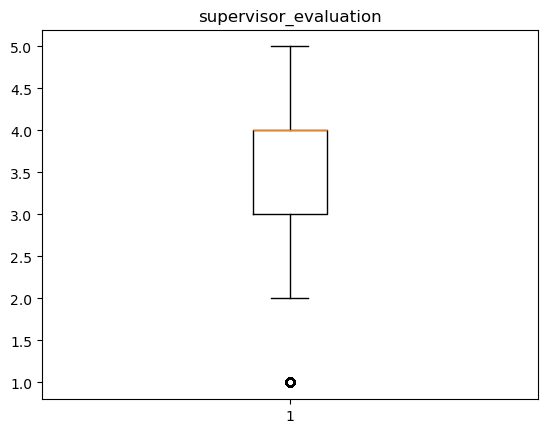

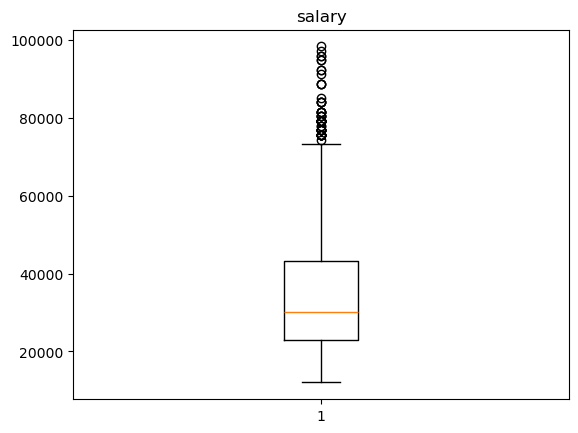

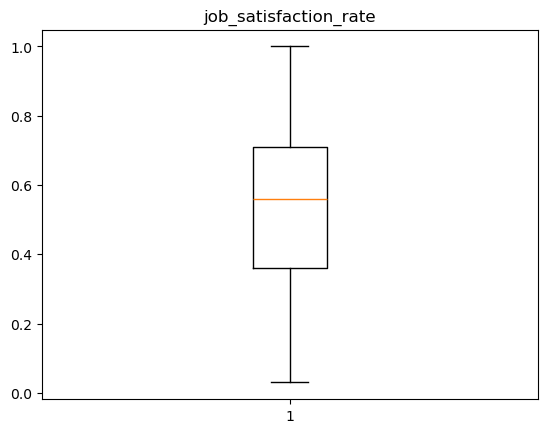

In [297]:
plt=reload(plt)
_for = [ 'employment_years', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate']
for i in _for:
  plt.boxplot(df_train_job[i])
  plt.title(i)
  plt.show()

* данные соответствуют описанию, аномалий нет, есть идентичные выбросы (будем иметь в виду)

In [298]:
df_train_job.query('supervisor_evaluation == 1')['supervisor_evaluation'].count()

201

In [299]:
df_train_job.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

* довольно много плохих работников

In [300]:
df_train_job[i] == np.nan

0       False
1       False
2       False
3       False
4       False
        ...  
3995    False
3996    False
3997    False
3998    False
3999    False
Name: job_satisfaction_rate, Length: 4000, dtype: bool

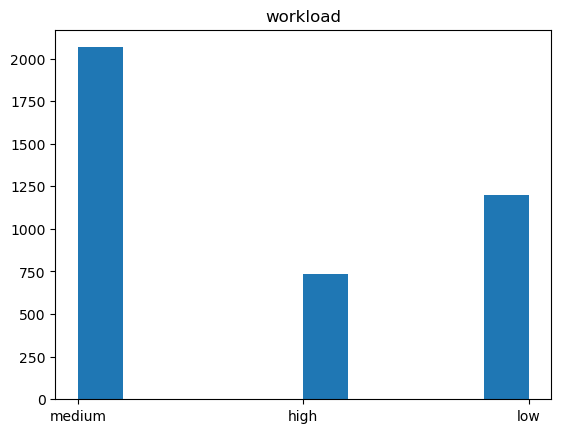

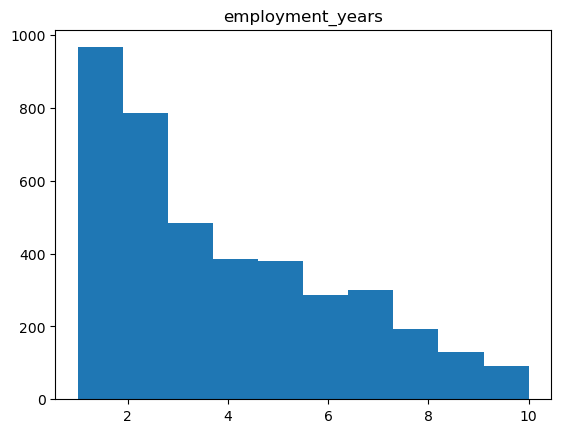

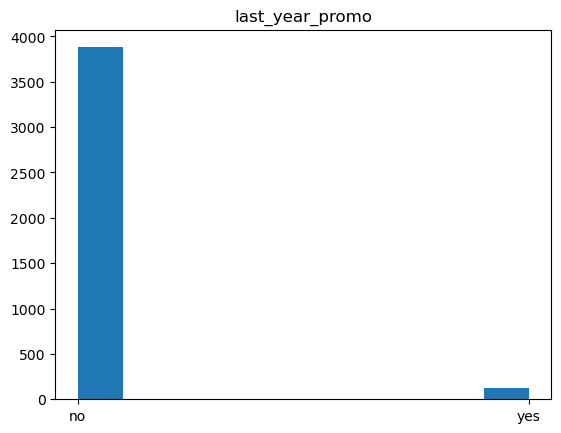

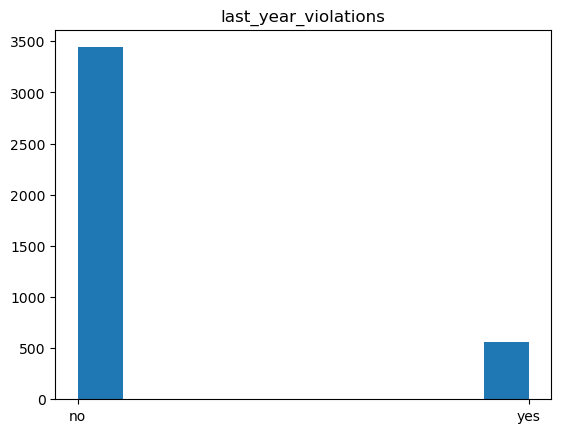

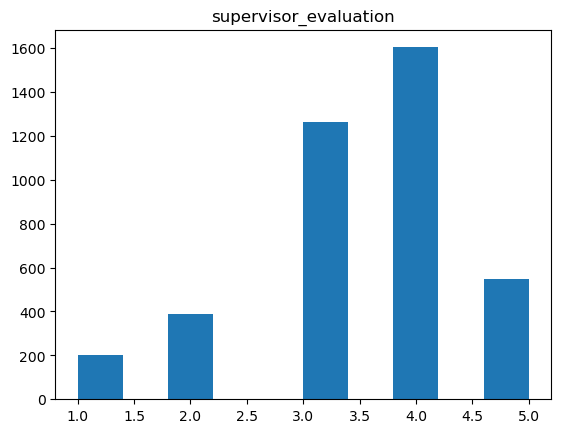

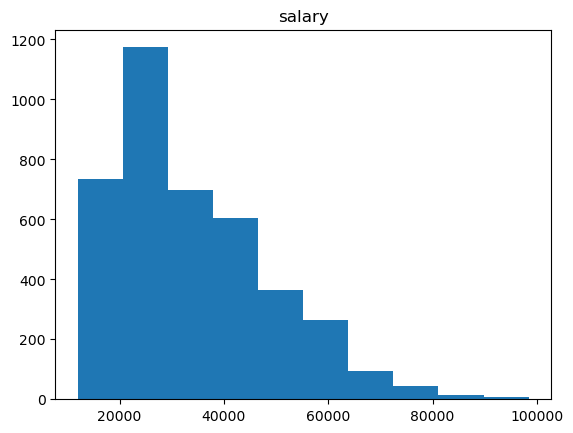

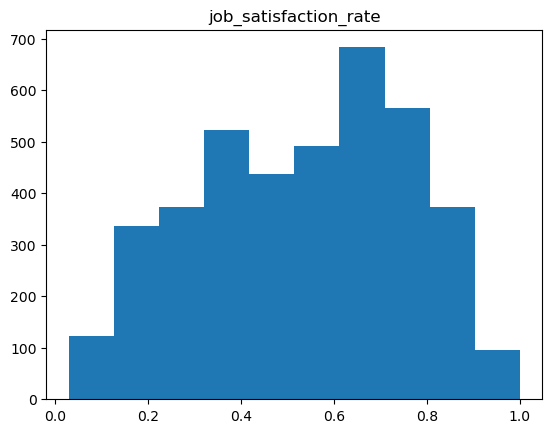

In [301]:
_for =['workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate']
for i in _for:
  plt.hist(df_train_job[i])
  plt.title(i)
  plt.show()

* некоторые данные похожи на порядковые категории `supervisor_evaluation`


### `test_features.csv`

In [302]:
df_test = pd.read_csv(pth + '/test_features.csv')#, sep=';',decimal=',')
display(df_test.head(5))
df_test.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


* пропусков нет
* формат данных корректный

In [303]:
_for =[ 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary']
for i in _for:
  display(f'{i} : {df_test[i].unique()}')
  display(f'-----------------------------')

"dept : ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']"

'-----------------------------'

"level : ['junior' 'middle' 'sinior' nan]"

'-----------------------------'

"workload : ['medium' 'low' 'high' ' ']"

'-----------------------------'

'employment_years : [ 2  1  5  6  3  9  7  4  8 10]'

'-----------------------------'

"last_year_promo : ['no' 'yes']"

'-----------------------------'

"last_year_violations : ['no' 'yes']"

'-----------------------------'

'supervisor_evaluation : [5 4 3 1 2]'

'-----------------------------'

'salary : [28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400\n 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200\n 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400\n 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000\n 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000\n 78000 75600 73200 84000 88800 92400]'

'-----------------------------'

* заменим пробелы на nan

In [304]:
for i in ['workload','dept']:
  df_test[i] = df_test[i].str.replace(' ','')
  df_test[i] = df_test[i].apply(lambda x: np.nan if x == '' else x )
  display(f'{i} : {df_test[i].unique()}')
  display(f'-----------------------------')

"workload : ['medium' 'low' 'high' nan]"

'-----------------------------'

"dept : ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]"

'-----------------------------'

### `test_target_job_satisfaction_rate.csv`

In [305]:
df_train_job_y = pd.read_csv(pth + '/test_target_job_satisfaction_rate.csv')#, sep=';',decimal=',')
display(df_train_job_y.head(5))
df_train_job_y.info()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


* пропусков нет
* формат данных корректный

In [306]:
df_train_job_y.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


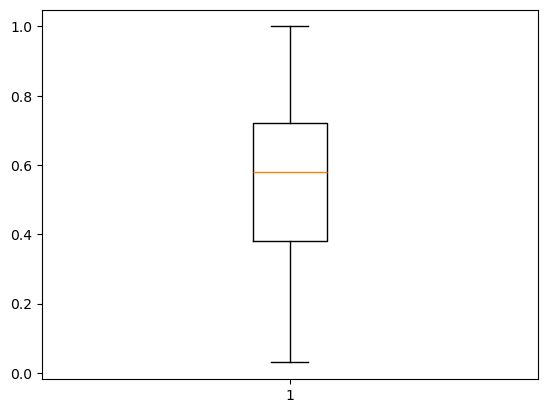

In [307]:
plt.boxplot(df_train_job_y['job_satisfaction_rate']);

* замечаний нет всё гуд

### Итог:

* заменили пробелы на nan, всего у нас 4000 рабочих будем на них тренировать модель

## Корреляционный анализ

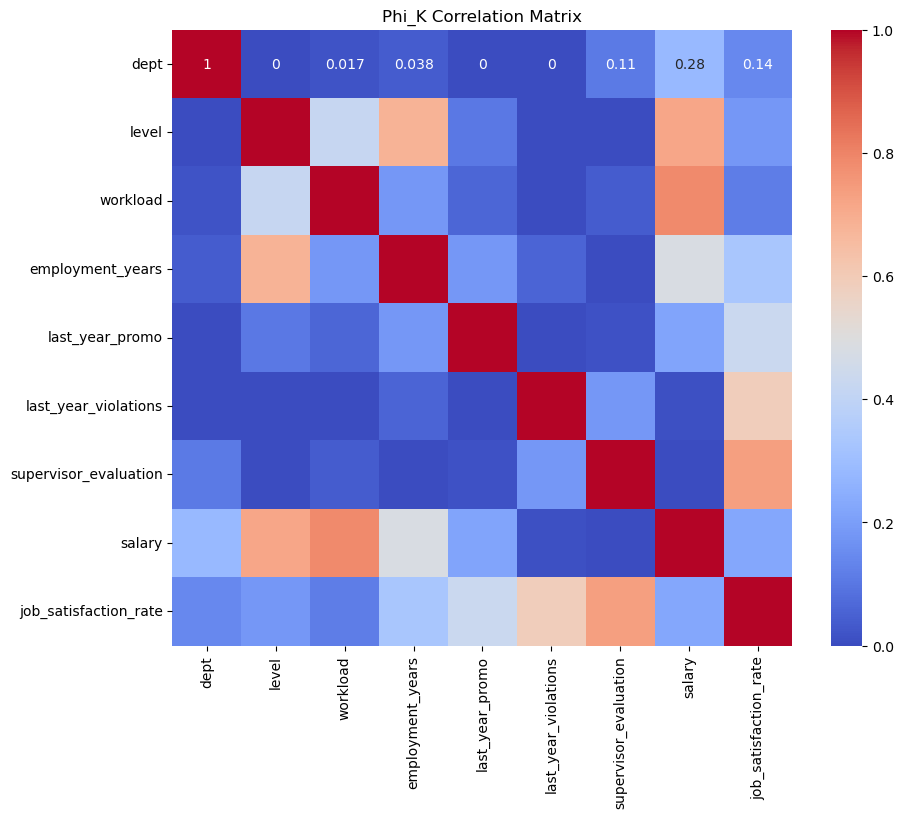

In [308]:
corr_matrix = df_train_job.drop('id',axis=1).\
phik_matrix(interval_cols=['employment_years',
                           'supervisor_evaluation',
                           'salary',
                           'job_satisfaction_rate'],\
            bins={'employment_years':10,'supervisor_evaluation':5,
                  'salary':10,'job_satisfaction_rate':100,})
# Визуализация матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

* очень высоких корреляций не видно, скорее всего мультиколлинеарности нет
* нулевой корреляции нет все признаки коррелируют
* довольно не плохо выглядит крайне высоких и крайне низких показателей нет


## Шаг 4. Подготовка данных

* чтоб все были связаны одним индексом


In [309]:
df_test['id'].isin(df_train_job_y['id']).sum()

2000

* все тестовые работники присутствуют в тренировочных данных

In [310]:
df_test = df_test.merge(df_train_job_y, on='id')

* свяжим целевой признак с тестовыми данными

In [311]:
y = (df_train_job['job_satisfaction_rate']*100).astype('int16')
y_test = (df_test['job_satisfaction_rate']*100).astype('int16')

* наши целевые признаки

In [312]:
# загружаем данные
X = df_train_job.copy()
X_test = df_test.copy()

# списки с названиями колонок
col_drop = ['id','job_satisfaction_rate']
ohe_columns = ['dept','last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload','supervisor_evaluation']
num_columns = ['salary','employment_years']

X = X.drop(columns = col_drop,axis=1)
X_test = X_test.drop(columns = col_drop,axis=1)
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(categories = \
                             [['junior', 'middle', 'sinior'],\
                              ['low', 'medium', 'high'],[1,2,3,4,5]
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)


## Шаг 5. Обучение моделей

##### Метрика SMAPE

In [313]:
# функция расчёта метрики SMAPE
def smape_metric(y_true, y_pred):
  return 1 / len(y_true) * np.sum(2 * np.abs(y_pred-y_true) / (np.abs(y_true) + \
                                                               np.abs(y_pred))*100)
# ссылка на свою метрику
scorer = make_scorer(smape_metric,greater_is_better=False)

In [314]:
#pipe_final = Pipeline([
#    ('preprocessor', data_preprocessor),
#    ('models', LinearRegression())])
#
#param_grid = [
#    # словарь для модели LinearRegression()
#    {'models': [LinearRegression()],
#     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
#    }]
#
#randomized_search = RandomizedSearchCV(
#    pipe_final,
#    param_grid,
#    cv=2,
#    scoring=scorer, #'r2',
#    n_jobs=-1,
#    error_score='raise',
#    random_state=RANDOM_STATE
#)
## игнорируем сообщения перед обучением
#warnings.filterwarnings('ignore')
#
## обучим модель с учителем y
#randomized_search.fit(X, y)
#
#best_model = randomized_search.best_estimator_.named_steps['models']
#display(f'Лучшая модель : {best_model}')
#
## попробуем предсказать
#pred = randomized_search.best_estimator_.predict(X_test)
#
## расчитаем свою метрику SMAPE
#display(f'SMAPE : {smape_metric(y_test,pred)}')

### Итоговый `Pipeline()`

In [315]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
     # словарь для модели LinearRegression()
    {'models': [LinearRegression()],
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

        # словарь для модели KNeighborsRegressor()
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

              # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,150),
        'models__min_samples_split': range(2,10),
        'preprocessor__num': [ MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=scorer, #'r2',
    n_jobs=-1,
    error_score='raise',
    random_state=RANDOM_STATE
)
# игнорируем сообщения перед обучением
warnings.filterwarnings('ignore')

# обучим модель с учителем y
randomized_search.fit(X, y)

best_model = randomized_search.best_estimator_.named_steps['models']
display(f'Лучшая модель : {best_model}')

# попробуем предсказать
pred = randomized_search.best_estimator_.predict(X)

# расчитаем свою метрику SMAPE
display(f'SMAPE на тренеровочном: {smape_metric(y,pred)}')

# попробуем предсказать
pred = randomized_search.best_estimator_.predict(X_test)

# расчитаем свою метрику SMAPE
display(f'SMAPE на тестовом : {smape_metric(y_test,pred)}')



'Лучшая модель : DecisionTreeRegressor(max_depth=27, min_samples_split=6, random_state=42)'

'SMAPE на тренеровочном: 7.550902976659988'

'SMAPE на тестовом : 13.852494525275922'

#### подбор гипер параметров

In [316]:
param_grid ={'models': [DecisionTreeRegressor(random_state=RANDOM_STATE,
                        min_samples_split = 2, min_samples_leaf = 3)],
        'models__max_depth': range(18,20),
        'models__max_features': range(9,12),
        'preprocessor__num': [MinMaxScaler(), 'passthrough']
             }
grid = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring = scorer,
    n_jobs=-1,
    error_score='raise',
)
# проверим качество модели на cross_val_score с метрикой SMAPE
test_cv= cross_val_score(grid, X, y, cv=5,scoring = scorer).mean()*-1
display(f'SMAPE на кросс-валидации :{test_cv}')


# обучим модель с учителем y
grid.fit(X, y)
best_model = grid.best_estimator_.named_steps['models']
display('---------------------------------------------------------------------------')
display(f'Лучшая модель : {best_model}')
display('---------------------------------------------------------------------------')
display(f'Лучшие пораметры : {grid.best_params_}')
display('---------------------------------------------------------------------------')

'SMAPE на кросс-валидации :14.445335519548872'

'---------------------------------------------------------------------------'

'Лучшая модель : DecisionTreeRegressor(max_depth=19, max_features=11, min_samples_leaf=3,\n                      random_state=42)'

'---------------------------------------------------------------------------'

"Лучшие пораметры : {'models': DecisionTreeRegressor(max_depth=19, max_features=11, min_samples_leaf=3,\n                      random_state=42), 'models__max_depth': 19, 'models__max_features': 11, 'preprocessor__num': MinMaxScaler()}"

'---------------------------------------------------------------------------'

#### обучим модель на лутчих параметрах

In [317]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(max_depth=19, max_features=11, min_samples_leaf=3, random_state=42))
])
pipe_final.fit(X,y)

# попробуем предсказать

pred = pipe_final.predict(X_test)
# расчитаем свою метрику SMAPE
display(f'SMAPE на тестовом : {smape_metric(y_test,pred)}')

'SMAPE на тестовом : 13.549710424512021'

* критерий успеха: SMAPE ≤15 на тестовой выборке преадалён УРА!

### Шаг 6. Вывод

* лутчая модель это дерево решений
* содрудник ставит оценку удовлитварённости анологичным способом взвешивая все плюсы и минусы и в какой-то момент повышает или понижает оценку, хорошо или плохо из нескольких факторов.


## Задача 2: предсказание увольнения сотрудника из компании

### Шаг 1 - 3.1. Загрузка данных

### `train_quit.csv`

In [318]:
df_train_quit = pd.read_csv(pth + '/train_quit.csv')
display(df_train_quit.head(5))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [319]:
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


* названия змеинные
* пропусков нет
* тип данных норм

In [320]:
df_train_quit['id'].duplicated().sum()

0

* все сотрудники уникальны

In [321]:
df_train_quit.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit'],
      dtype='object')

In [322]:
_for =[ 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit']
for i in _for:
  display(df_train_quit[i].unique())
  display(f'-----------------------------')

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

'-----------------------------'

array(['middle', 'junior', 'sinior'], dtype=object)

'-----------------------------'

array(['high', 'medium', 'low'], dtype=object)

'-----------------------------'

array([ 2,  5,  1,  8,  4,  7,  3,  9,  6, 10], dtype=int64)

'-----------------------------'

array(['no', 'yes'], dtype=object)

'-----------------------------'

array(['no', 'yes'], dtype=object)

'-----------------------------'

array([4, 1, 3, 5, 2], dtype=int64)

'-----------------------------'

array([54000, 27600, 37200, 24000, 25200, 18000, 44400, 19200, 45600,
       57600, 33600, 16800, 22800, 26400, 82800, 32400, 39600, 30000,
       46800, 12000, 15600, 58800, 60000, 66000, 21600, 38400, 62400,
       40800, 56400, 34800, 28800, 52800, 20400, 36000, 61200, 48000,
       43200, 73200, 31200, 78000, 64800, 72000, 94800, 96000, 63600,
       79200, 55200, 42000, 49200, 50400, 14400, 13200, 51600, 67200,
       88800, 68400, 69600, 70800, 84000, 81600, 87600, 75600, 91200,
       76800, 74400, 80400, 85200, 86400, 92400], dtype=int64)

'-----------------------------'

array(['no', 'yes'], dtype=object)

'-----------------------------'

* никаких пустых данных нет
* признаки теже

In [323]:
_for =[ 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit']
for i in _for:
  display(df_train_quit[i].value_counts())
  display(f'-----------------------------')
df_train_quit[['employment_years','salary']].describe()

dept
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: count, dtype: int64

'-----------------------------'

level
junior    1949
middle    1694
sinior     357
Name: count, dtype: int64

'-----------------------------'

workload
medium    2118
low       1208
high       674
Name: count, dtype: int64

'-----------------------------'

employment_years
1     985
2     777
3     479
4     393
5     362
7     308
6     296
8     174
9     136
10     90
Name: count, dtype: int64

'-----------------------------'

last_year_promo
no     3887
yes     113
Name: count, dtype: int64

'-----------------------------'

last_year_violations
no     3455
yes     545
Name: count, dtype: int64

'-----------------------------'

supervisor_evaluation
4    1654
3    1233
5     520
2     391
1     202
Name: count, dtype: int64

'-----------------------------'

salary
24000    200
27600    185
19200    182
26400    180
33600    164
        ... 
88800      2
91200      1
85200      1
86400      1
92400      1
Name: count, Length: 69, dtype: int64

'-----------------------------'

quit
no     2872
yes    1128
Name: count, dtype: int64

'-----------------------------'

,employment_years,salary
count,4000.000000,4000.000000
mean,3.701500,33805.800000
std,2.541852,15152.415163
min,1.000000,12000.000000
25%,2.000000,22800.000000
50%,3.000000,30000.000000
75%,6.000000,43200.000000
max,10.000000,96000.000000


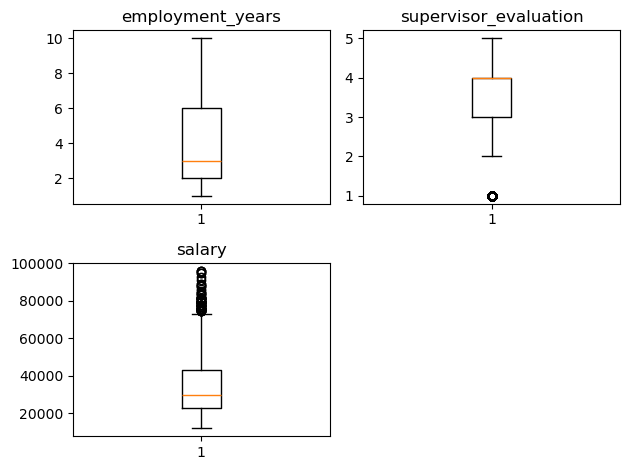

In [324]:
_for = [ 'employment_years', 'supervisor_evaluation',
       'salary']

j=0
for i in _for:

    # Set up the plot
   ax = plt.subplot(2, 2, j + 1)
   j = j+1

    # Draw the plot
   ax.boxplot(df_train_quit[i])

    # Title and labels
   ax.set_title(i)
plt.tight_layout()
plt.show()

In [325]:
df_train_quit.query('supervisor_evaluation == 1')['supervisor_evaluation'].count()

202

* плюс ещё один туниядец

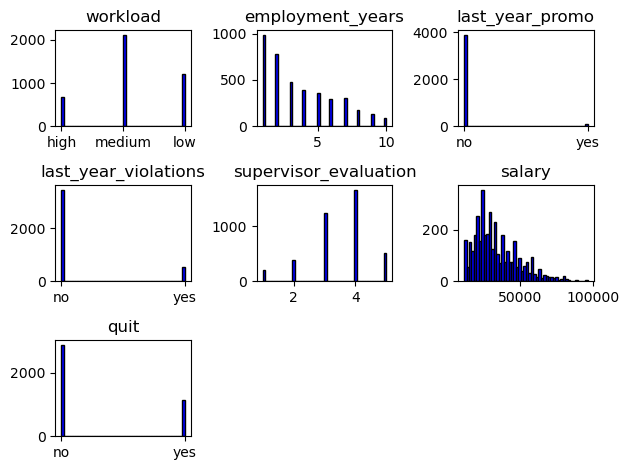

In [326]:
_for =['workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit']
j=0
for i in _for:

    # Set up the plot
   ax = plt.subplot(3, 3, j + 1)
   j = j+1

    # Draw the plot
   ax.hist(df_train_quit[i], bins = 50,
             color = 'blue', edgecolor = 'black')

    # Title and labels
   ax.set_title(i)
plt.tight_layout()
plt.show()

### `test_target_quit.csv`

In [327]:
df_test_target_quit = pd.read_csv(pth + '/test_target_quit.csv')#, sep=';',decimal=',')
display(df_test_target_quit.head(5))

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [328]:
df_test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


* пропусков нет
* формат данных корректный

In [329]:
df_test_target_quit['quit'].unique()

array(['yes', 'no'], dtype=object)

* замечаний нет всё гуд

#### Итог:

* nan в дальнейшем обработаем в конвеером пайпланом


### Шаг. 3.2. портрет «уволившегося сотрудника»

* Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.


In [330]:
df_train_quit.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit'],
      dtype='object')

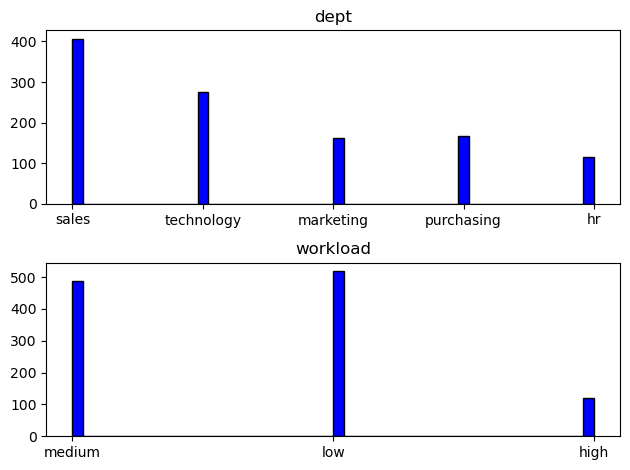

In [331]:
_for =['dept', 'workload']
j=0
for i in _for:

    # Set up the plot
   ax = plt.subplot(2, 1, j + 1)
   j = j+1

    # Draw the plot
   ax.hist(df_train_quit.query('quit == "yes"')[i], bins = 50,
             color = 'blue', edgecolor = 'black')

    # Title and labels
   ax.set_title(i)
plt.tight_layout()
plt.show()

In [332]:
df_train_quit.groupby(['quit'])['salary'].mean()

quit
no     37702.228412
yes    23885.106383
Name: salary, dtype: float64

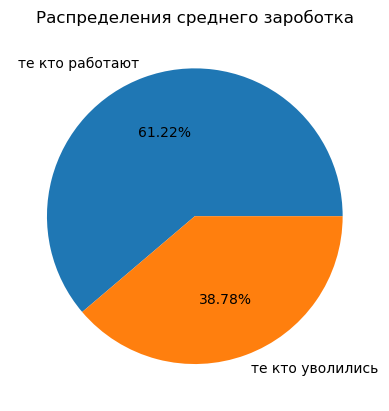

In [333]:
def pct(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.2f}%'.format(pct, v=val)
        return my_format

s = df_train_quit.groupby(['quit'])['salary'].mean()
plt.pie(s,labels = ['те кто работают', 'те кто уволились'], autopct=pct(s))
plt.title('Распределения среднего зароботка')
plt.show()

* Больше всего увольняются из отдел продаж, кто особо не загружен работай и меньше среднего зарабатывает

### Шаг 3.3. визуализация ушедших и оставшихся

In [334]:
df_test['id'].isin(df_test_target_quit['id']).sum()

2000

* все сотрудники индефицированы с целевым признаком

In [335]:
df_test = df_test.merge(df_test_target_quit, on='id')

* свяжим целевой признак с тестовыми данными

In [336]:
df_test.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate', 'quit'],
      dtype='object')

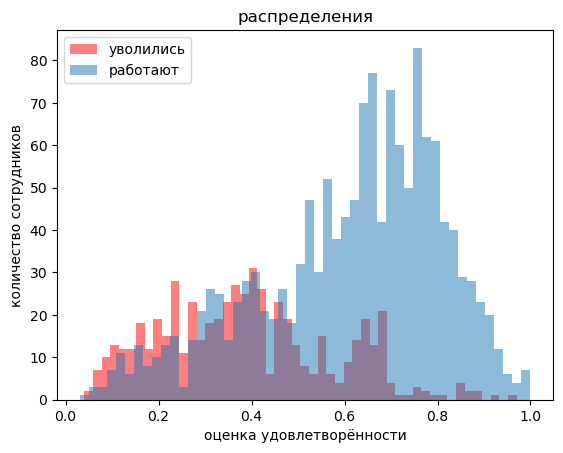

In [337]:
plt.hist(df_test.query('quit == "yes"')['job_satisfaction_rate'],
         alpha=0.5, # the transaparency parameter
         label='уволились', color = 'red',bins=50)

plt.hist(df_test.query('quit == "no"')['job_satisfaction_rate'],
         alpha=0.5,
         label='работают',bins=50)

plt.legend(['уволились','работают'])
plt.title('распределения')
plt.xlabel('оценка удовлетворённости')
plt.ylabel('количество сотрудников')
plt.show()

* всё верно похоже и правда сотрудники поставившие низкий уровень удовлетворённости чаще увольняются

## Шаг 4. Добавление нового входного признака

In [338]:
df_train_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no


In [339]:
df_train_quit['job_satisfaction_rate'] = \
pipe_final.predict(df_train_quit.drop(['quit','id'],axis=1))
df_train_quit['job_satisfaction_rate'] = df_train_quit['job_satisfaction_rate'].astype('int16')
df_train_quit.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,60
1,814010,sales,junior,medium,2,no,no,4,27600,no,82
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,33
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,35
4,910140,marketing,junior,medium,2,no,no,5,25200,no,81


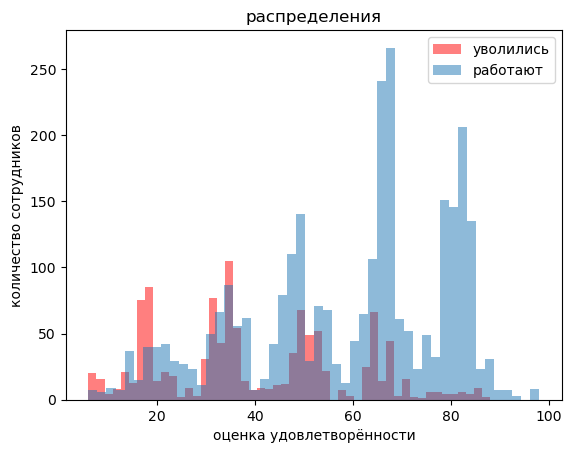

In [340]:
plt.hist(df_train_quit.query('quit == "yes"')['job_satisfaction_rate'],
         alpha=0.5, # the transaparency parameter
         label='уволились', color = 'red',bins=50)

plt.hist(df_train_quit.query('quit == "no"')['job_satisfaction_rate'],
         alpha=0.5,
         label='работают',bins=50)

plt.legend(['уволились','работают'])
plt.title('распределения')
plt.xlabel('оценка удовлетворённости')
plt.ylabel('количество сотрудников')
plt.show()

* модель предсказывала по пять основных групп

## Корреляционный анализ

* посмотрим на `quit` как он будет коррелировать

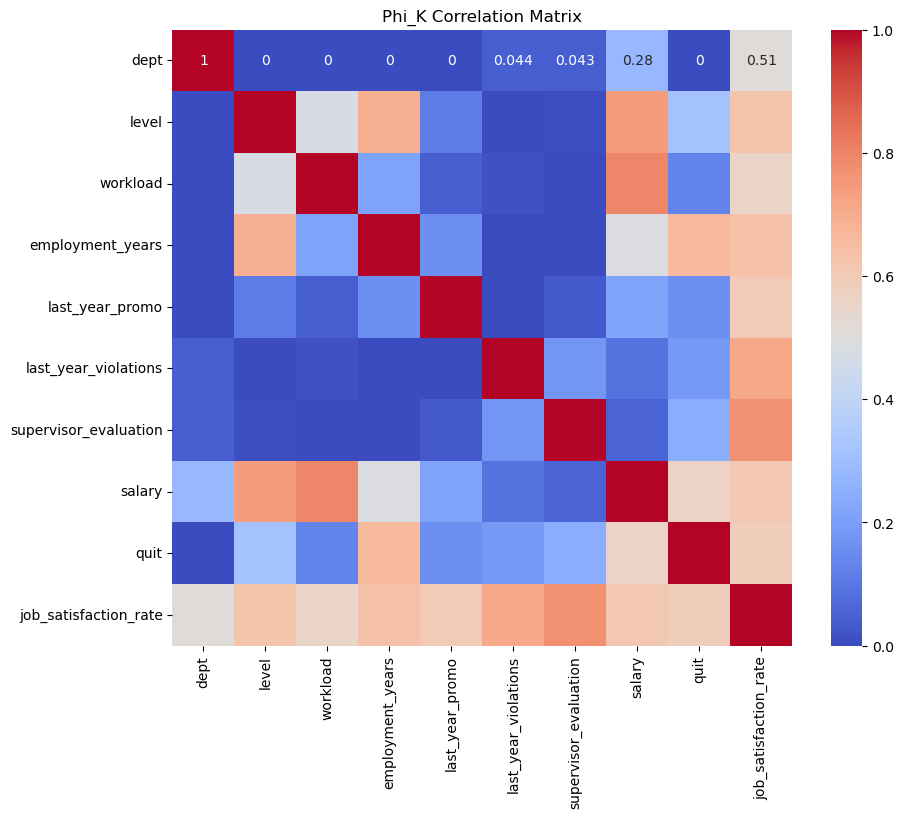

In [341]:
corr_matrix = df_train_quit.drop('id',axis=1).\
phik_matrix(interval_cols=['employment_years',
                           'supervisor_evaluation',
                           'salary',
                           'job_satisfaction_rate'],\
            bins={'employment_years':10,'supervisor_evaluation':5,
                  'salary':10,'job_satisfaction_rate':100,})
# Визуализация матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

* очень высоких корреляций не видно и предсказанный `job_satisfaction_rate` ведёт себя хорошо, мультиколлинеарности нет
* есть нулевая корреляция с `dept` , значит можно этот признак исключить
* довольно не плохо выглядит крайне высоких и крайне низких показателей нет

## Шаг 5. Подготовка данных

#### кодирование целевого признака

#### подготовка и кодирования признаков

#### подготовка параметров

#### пайплайн

* собрал всё вместе внизу так легче настраивать и тестировать

## Шаг 6. Обучение модели

In [342]:
# используем кодировщик для целевого признака
label_encoder = LabelEncoder()
label_encoder.fit(df_train_quit['quit'])
y_train = label_encoder.transform(df_train_quit['quit'])
y_test = label_encoder.transform(df_test['quit'])

# загружаем данные
X = df_train_quit.copy()
X_test = df_test.copy()
X_test['job_satisfaction_rate'] = (df_test['job_satisfaction_rate'] * 100).astype('int16')

# списки с названиями колонок
col_drop = ['id','quit']
ohe_columns = ['dept','last_year_promo','last_year_violations']
ord_columns = ['level','workload','supervisor_evaluation']
num_columns =['salary','employment_years','job_satisfaction_rate']

# набор для обучения
X = X.drop(columns = col_drop,axis=1)

# тестовый набор для оценки качества
X_test = X_test.drop(columns = col_drop,axis=1)

# пайплайн для подготовки значений из ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline([('simpleImputer_ohe',\
                      SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('ohe',\
                      OneHotEncoder(drop='first', handle_unknown='error', sparse=False))]
                    )

# пайплайн для подготовки значений из ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline([('simpleImputer_ohe',\
                      SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('ohe',\
                      OneHotEncoder(drop='first', handle_unknown='error', sparse=False))]
                    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[['junior', 'middle', 'sinior'],\
                 ['low', 'medium', 'high'],[1,2,3,4,5]],\
                handle_unknown='use_encoded_value', unknown_value=np.nan)
     ),\
      ('simpleImputer_after_ord',\
       SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(transformers = \
                                      [('ohe', ohe_pipe, ohe_columns),
                                       ('ord', ord_pipe, ord_columns),
                                       ('num', MinMaxScaler(), num_columns)
                                      ], remainder='passthrough')

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE,\
                                          min_samples_split=2, max_features=9)],
        'models__max_depth': range(2,22),
        'models__min_samples_leaf': range(2,22),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

]
# пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise',
)
randomized_search.fit(X, y_train)

display('Лучшая модель и её параметры:', randomized_search.best_estimator_.named_steps['models'])
display(f'Метрика лучшей модели на тренировочной выборке: {randomized_search.best_score_:.2f}')
# попробуем предсказать
pred = randomized_search.best_estimator_.predict_proba(X_test)[:,1]

# расчитаем свою метрику SMAPE
display(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, pred):.2f}')

'Лучшая модель и её параметры:'

DecisionTreeClassifier(max_depth=20, max_features=9, min_samples_leaf=17,
                       random_state=42)

'Метрика лучшей модели на тренировочной выборке: 0.93'

'Метрика ROC-AUC на тестовой выборке: 0.92'

In [343]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE,
                                      min_samples_split=2, max_features=9))
])
param_grid ={'models__max_depth': range(5,7),
             'models__min_samples_leaf': range(20,22),
             'preprocessor__num': [MinMaxScaler(), 'passthrough']
             }
grid = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    error_score='raise',
)

display(cross_val_score(grid, X, y_train, cv=5, scoring = "roc_auc").mean())

# обучим модель с учителем y
grid.fit(X, y_train)

best_model = grid.best_estimator_.named_steps['models']
display(f'Лучшая модель : {best_model}')
display(f'Лучшие пораметры : {grid.best_params_}')

# попробуем предсказать
pred = grid.best_estimator_.predict_proba(X_test)[:,1]

# расчитаем свою метрику SMAPE
display(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, pred):.2f}')

0.929164504034355

'Лучшая модель : DecisionTreeClassifier(max_depth=5, max_features=9, min_samples_leaf=21,\n                       random_state=42)'

"Лучшие пораметры : {'models__max_depth': 5, 'models__min_samples_leaf': 21, 'preprocessor__num': MinMaxScaler()}"

'Метрика ROC-AUC на тестовой выборке: 0.94'

In [344]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', best_model)
])
pipe_final.fit(X,y_train)

# попробуем предсказать
pred = pipe_final.predict_proba(X_test)[:,1]

# расчитаем свою метрику SMAPE
display(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, pred):.2f}')

'Метрика ROC-AUC на тестовой выборке: 0.94'

* критерий успеха: ROC-AUC ≥0.91 пройден :-)

## Общий вывод

**Задача:**
* построить модель, которая сможет и без проведения опроса работников предсказать что сотрудник может уволится из компании.

**Этапы:**
* построили модель предсказания уровня удовлетворённости
* с помощью этой модели предсказали уровень удовлетворённости сотрудников не участвующих в опросе
* далее полученный уровень удовлетворённости использовали в окончательной модели
* на выходе имеем возможность предсказывать кто уволится и без опроса работников, хотя проведения опроса будет не лишним

**Вывод**
* модель помогла в том что определила что большинство работников честно ставят оценку удовлетворённости
* руководству необходимо обратить внимание на статистику и более глубже изучить портрет уволившихся сотрудников
* проанализировать показатель удовлетворённости по разным категориям




In [345]:
'end'

'end'